In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import scikitplot as skplt

from IPython.display import Image
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D
from scipy import interp
from scipy.stats import randint as sp_randint
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, classification_report, make_scorer, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import export_graphviz
from sklearn.utils import resample

# Classification (with labels given by the clustering)

## Decision tree

In [2]:
customer_profile = pd.read_csv('datasets/customer_indicators.csv', index_col=0)
customer_clustering = pd.read_csv('datasets/clustering_labels.csv', index_col=0)
customer_clustering = customer_clustering.merge(customer_profile[['CustomerID', 'RFrequency','Max_items']], on='CustomerID')
del customer_profile
customer_clustering

,RMonetary,Delta,Recency,CustomerID,Label,RFrequency,Max_items
0,1.071,2.563,2,12347,High,0.019126,676
1,0.706,2.452,75,12348,Medium,0.014134,1248
2,0.725,2.417,36,12352,Medium,0.026820,125
3,0.914,2.481,23,12356,High,0.009901,1198
4,0.791,2.176,2,12358,Medium,0.013333,144
...,...,...,...,...,...,...,...
3855,1.407,0.000,134,18268,Low,1.000000,2
3856,2.227,0.000,366,18269,Low,1.000000,76
3857,2.240,0.000,74,18278,Low,1.000000,66
3858,2.257,0.000,278,18280,Low,1.000000,45


In [3]:
df_majority = customer_clustering[customer_clustering.Label == 'Medium']
df_minority = customer_clustering[customer_clustering.Label == 'High']
df_middle   = customer_clustering[customer_clustering.Label == 'Low']

customer_clustering.Label.value_counts()

Medium    1698
Low       1250
High       912
Name: Label, dtype: int64

In [4]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority))

# Upsample minority class
df_middle_upsampled = resample(df_middle, 
                               replace=True,     # sample with replacement
                               n_samples=len(df_majority))

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled, df_middle_upsampled])
 
# Display new class counts
customer_clustering = df_upsampled
df_upsampled.Label.value_counts()

Low       1698
High      1698
Medium    1698
Name: Label, dtype: int64

In [5]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable + '_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [6]:
variables = ['Label']

# Discretize data, in this case only Label
customer_clustering = discretize_data(customer_clustering, variables)

# Drop the categorical variables since we don't need them anymore 
customer_clustering = customer_clustering[['Delta', 'Label_num', 'RFrequency','Max_items']]

label = customer_clustering.pop('Label_num')

scaler = StandardScaler()
customer_clustering = scaler.fit_transform(customer_clustering.values)

train_set, test_set, train_label, test_label = train_test_split(
                                                 customer_clustering, label, stratify=label, test_size=0.3)

## Expected prediction

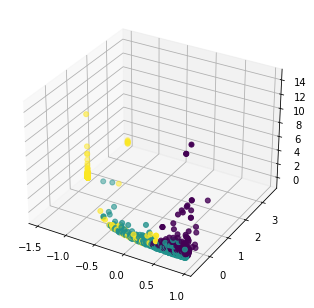

In [7]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=test_label.values, s=25)
plt.show()

## Decision Tree

In [8]:
# Decision tree

param_dist = {"max_depth": [2,3,5,6,7,10,12],
              "min_samples_split": sp_randint(20, 30),
              "min_samples_leaf": sp_randint(5, 30),
              "criterion": ["entropy", "gini"],
              "splitter": ["best"]
              }

n_iter_search = 50

dec_t = tree.DecisionTreeClassifier()

grid_search = RandomizedSearchCV(dec_t, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [9]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 26, 'splitter': 'best'}
Mean and std of this setting  0.8791023842917249 0.011714228902003418


In [10]:
# Decision tree best setting parameters

dec_t = tree.DecisionTreeClassifier(criterion='entropy', splitter='best',
                                  max_depth=5,
                                  min_samples_split=24, min_samples_leaf=13).fit(train_set, train_label)

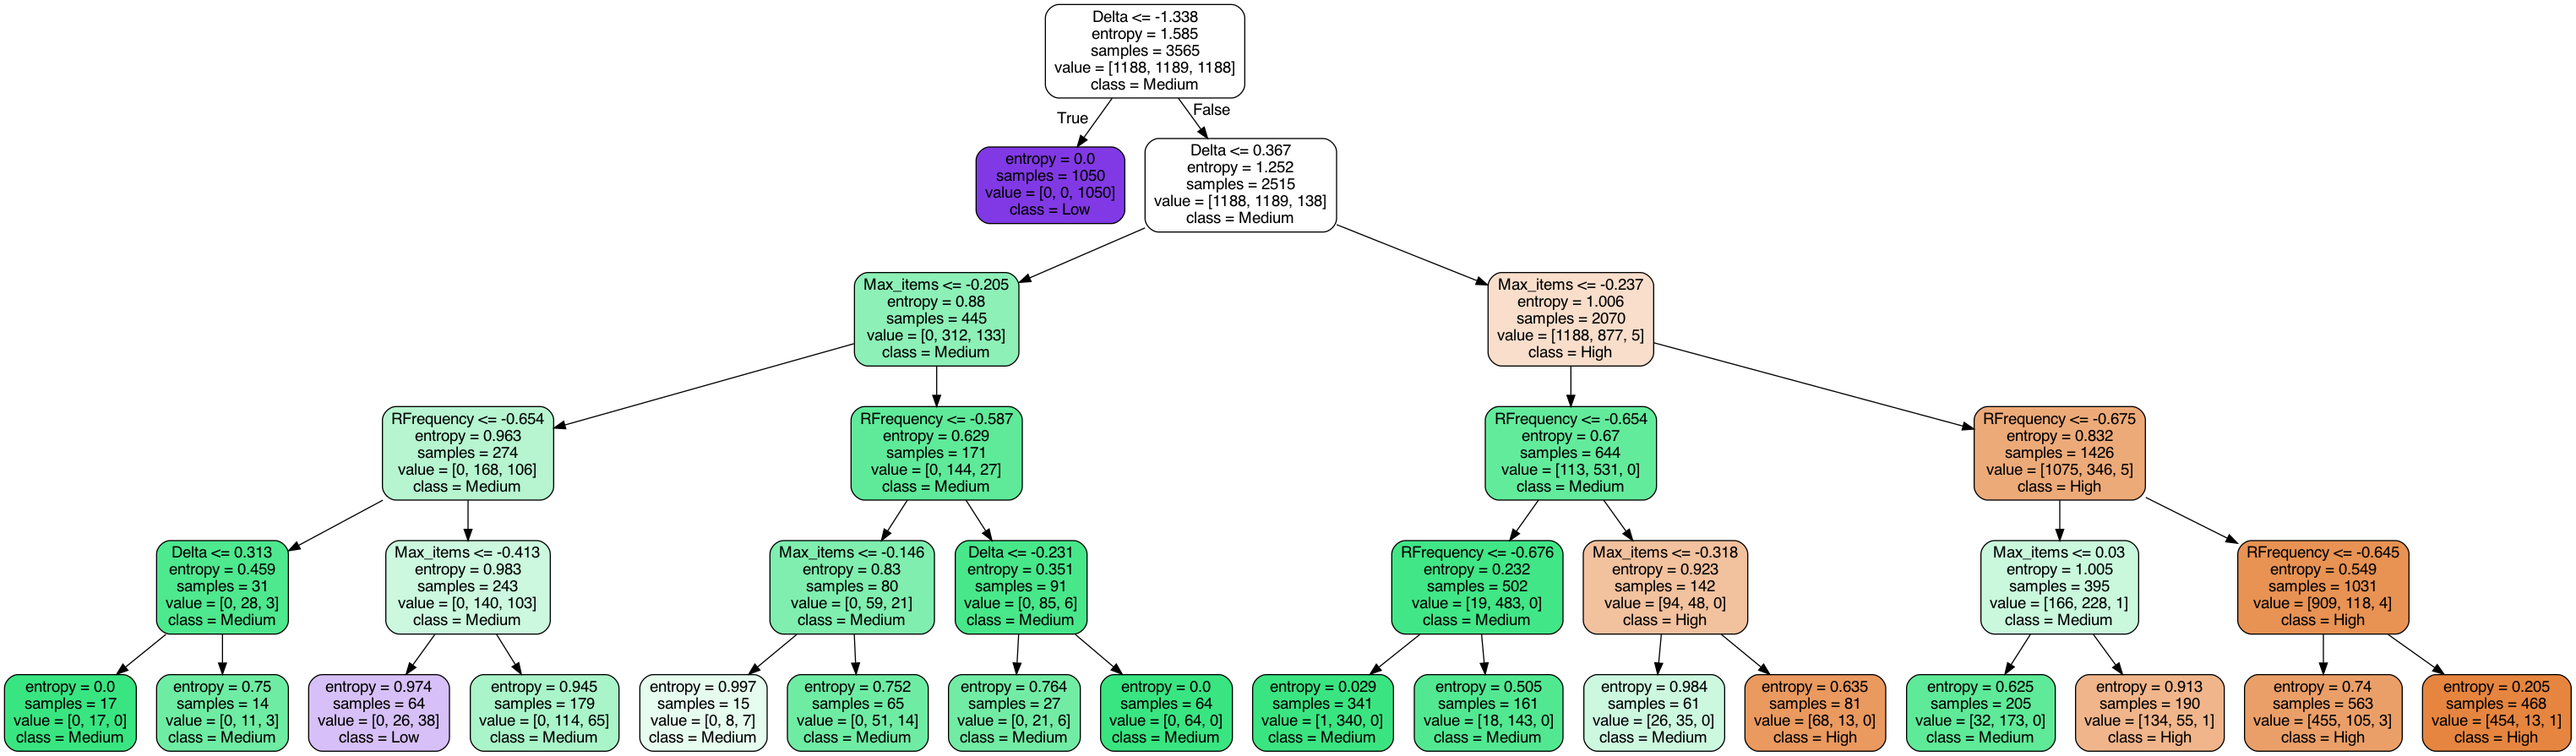

In [11]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                         feature_names=['Delta', 'RFrequency','Max_items'],
                         class_names=['High', 'Medium', 'Low'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [12]:
def predict(model, train_set, test_set):
    train_pred = model.predict(train_set)
    test_pred = model.predict(test_set)
    return train_pred, test_pred

In [13]:
# Predict phase

train_pred_dt, test_pred_dt = predict(dec_t, train_set, test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [14]:
def print_scores(train_label, train_pred, test_label, test_pred, target_names_):
    print('Accuracy train set:', metrics.accuracy_score(train_label, train_pred))
    print('Accuracy test set: ', metrics.accuracy_score(test_label, test_pred))
    print()
    print('F1 score train set:', metrics.f1_score(train_label, train_pred, average='weighted'))
    print('F1 score test set: ', metrics.f1_score(test_label, test_pred, average='weighted'))
    print('Train:')
    print(classification_report(train_label, train_pred, target_names=target_names_))
    print('-' * 53)
    print('Test:')
    print(classification_report(test_label, test_pred, target_names=target_names_))

In [15]:
print_scores(train_label, train_pred_dt, test_label, test_pred_dt, ['High', 'Medium', 'Low'])

Accuracy train set: 0.890883590462833
Accuracy test set:  0.894702419882276

F1 score train set: 0.8911149748732469
F1 score test set:  0.8951359637273095
Train:
              precision    recall  f1-score   support

        High       0.85      0.94      0.89      1188
      Medium       0.85      0.82      0.84      1189
         Low       0.98      0.92      0.95      1188

    accuracy                           0.89      3565
   macro avg       0.89      0.89      0.89      3565
weighted avg       0.89      0.89      0.89      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.86      0.92      0.89       510
      Medium       0.86      0.84      0.85       509
         Low       0.98      0.92      0.95       510

    accuracy                           0.89      1529
   macro avg       0.90      0.89      0.90      1529
weighted avg       0.90      0.89      0.90      1529



In [16]:
# Compute confusion matrix.

print('Train:')
print(confusion_matrix(train_label, train_pred_dt))
print('-' * 18)
print('Test:')
print(confusion_matrix(test_label, test_pred_dt))

Train:
[[1111   77    0]
 [ 186  977   26]
 [   5   95 1088]]
------------------
Test:
[[471  37   2]
 [ 75 426   8]
 [  4  35 471]]


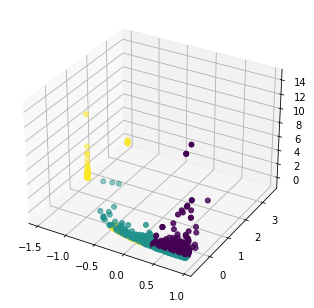

In [17]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=test_pred_dt, s=25)
plt.show()

## SVM

In [18]:
# Binarize the output
test_label_binarized = label_binarize(test_label, classes=[0, 1, 2])
train_label_binarized = label_binarize(train_label, classes=[0, 1, 2])

svm = SVC(kernel='poly', C=0.5, gamma='scale').fit(train_set, train_label)
svm_binarize = OneVsRestClassifier(svm).fit(train_set, train_label_binarized)

In [19]:
# Predictions

train_pred_svm_binarized, test_pred_svm_binarized = predict(svm_binarize, train_set, test_set)
train_pred_svm, test_pred_svm = predict(svm, train_set, test_set)

In [20]:
# Compute the performance of the model

print_scores(train_label, train_pred_svm, test_label, test_pred_svm, ['High', 'Medium', 'Low'])

Accuracy train set: 0.835063113604488
Accuracy test set:  0.8306082406801831

F1 score train set: 0.8384261526701544
F1 score test set:  0.8338646774540752
Train:
              precision    recall  f1-score   support

        High       0.84      0.76      0.80      1188
      Medium       0.71      0.86      0.78      1189
         Low       1.00      0.89      0.94      1188

    accuracy                           0.84      3565
   macro avg       0.85      0.84      0.84      3565
weighted avg       0.85      0.84      0.84      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.82      0.76      0.79       510
      Medium       0.71      0.84      0.77       509
         Low       1.00      0.90      0.94       510

    accuracy                           0.83      1529
   macro avg       0.84      0.83      0.83      1529
weighted avg       0.84      0.83      0.83      1529



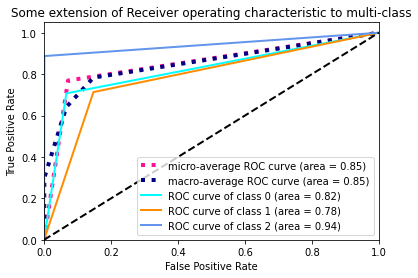

In [21]:
n_classes = 3
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_label_binarized[:, i], train_pred_svm_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(train_label_binarized.ravel(), train_pred_svm_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

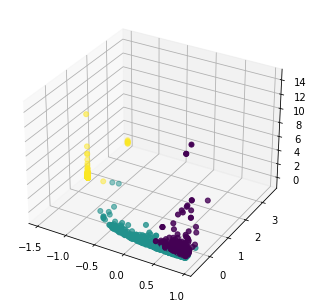

In [22]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=test_pred_svm, s=25)
plt.show()

## KNN

In [23]:
knn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [24]:
train_pred_knn, test_pred_knn = predict(knn, train_set, test_set)

In [25]:
print_scores(train_label, train_pred_knn, test_label, test_pred_knn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.9124824684431978
Accuracy test set:  0.8724656638325703

F1 score train set: 0.9120364725122213
F1 score test set:  0.871171668005796
Train:
              precision    recall  f1-score   support

        High       0.86      0.98      0.91      1188
      Medium       0.91      0.82      0.86      1189
         Low       0.98      0.94      0.96      1188

    accuracy                           0.91      3565
   macro avg       0.92      0.91      0.91      3565
weighted avg       0.92      0.91      0.91      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.82      0.95      0.88       510
      Medium       0.86      0.75      0.80       509
         Low       0.95      0.92      0.93       510

    accuracy                           0.87      1529
   macro avg       0.87      0.87      0.87      1529
weighted avg       0.87      0.87      0.87      1529



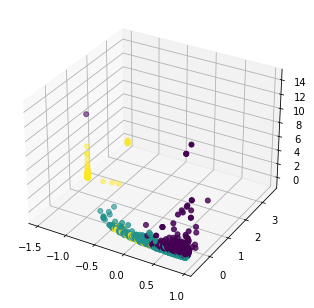

In [26]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=test_pred_knn, s=25)
plt.show()

## Classification with Random Forest

In [27]:
# Define and fit a random forest.

param_dist = {"max_depth": [2, 3, 5, 6, 7, 10, 12, None],
              "max_features": sp_randint(1,len(train_set[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight": ['balanced', None, {0: 0.25, 1: 0.50, 2:0.25}]}

n_iter_search = 50

rf = RandomForestClassifier(n_estimators=30)
grid_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [28]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 13, 'min_samples_split': 28}
Mean and std of this setting  0.876577840112202 0.01206497232404295


In [29]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=2,
                             class_weight= 'balanced',
                             max_depth=5, 
                             min_samples_split=20,
                             min_samples_leaf=18,
                             bootstrap=False).fit(train_set, train_label)

In [30]:
train_pred_rf, test_pred_rf = predict(rf, train_set, test_set)

In [31]:
print_scores(train_label, train_pred_rf, test_label, test_pred_rf, ['High', 'Medium', 'Low'])

Accuracy train set: 0.9004207573632539
Accuracy test set:  0.9012426422498365

F1 score train set: 0.9009276220509488
F1 score test set:  0.9017998236557151
Train:
              precision    recall  f1-score   support

        High       0.87      0.94      0.90      1188
      Medium       0.85      0.85      0.85      1189
         Low       0.99      0.91      0.95      1188

    accuracy                           0.90      3565
   macro avg       0.90      0.90      0.90      3565
weighted avg       0.90      0.90      0.90      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.87      0.94      0.90       510
      Medium       0.85      0.85      0.85       509
         Low       0.99      0.91      0.95       510

    accuracy                           0.90      1529
   macro avg       0.90      0.90      0.90      1529
weighted avg       0.90      0.90      0.90      1529



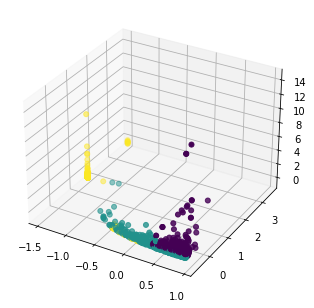

In [32]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=test_pred_rf, s=25)
plt.show()

## Neural networks

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(1, len(customer_clustering[0]))))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
train_label_nn = to_categorical(train_label, 3)
test_label_nn = to_categorical(test_label, 3)

In [35]:
history = model.fit(train_set, train_label_nn,
                    epochs=40,
                    batch_size=256,
                    validation_split=0.3)

Epoch 1/40
10/10 [==============================] - 0s 22ms/step - loss: 1.0718 - accuracy: 0.4369 - val_loss: 0.9836 - val_accuracy: 0.8028
Epoch 2/40
10/10 [==============================] - 0s 4ms/step - loss: 0.9541 - accuracy: 0.6501 - val_loss: 0.8634 - val_accuracy: 0.7710
Epoch 3/40
10/10 [==============================] - 0s 6ms/step - loss: 0.8465 - accuracy: 0.7142 - val_loss: 0.7486 - val_accuracy: 0.7776
Epoch 4/40
10/10 [==============================] - 0s 5ms/step - loss: 0.7462 - accuracy: 0.7375 - val_loss: 0.6450 - val_accuracy: 0.8084
Epoch 5/40
10/10 [==============================] - 0s 5ms/step - loss: 0.6594 - accuracy: 0.7547 - val_loss: 0.5653 - val_accuracy: 0.8178
Epoch 6/40
10/10 [==============================] - 0s 6ms/step - loss: 0.5834 - accuracy: 0.7800 - val_loss: 0.5105 - val_accuracy: 0.8308
Epoch 7/40
10/10 [==============================] - 0s 8ms/step - loss: 0.5495 - accuracy: 0.7695 - val_loss: 0.4762 - val_accuracy: 0.8346
Epoch 8/40
10/10 [=

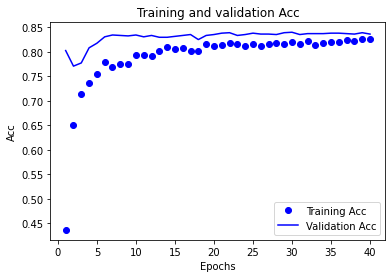

In [36]:
lw = 2
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [37]:
train_pred_nn = np.argmax(model.predict(train_set), axis=-1)
test_pred_nn = np.argmax(model.predict(test_set), axis=-1)

In [38]:
print_scores(train_label, train_pred_nn, test_label, test_pred_nn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8375876577840112
Accuracy test set:  0.8345323741007195

F1 score train set: 0.8401515030954462
F1 score test set:  0.8365665610308892
Train:
              precision    recall  f1-score   support

        High       0.81      0.83      0.82      1188
      Medium       0.74      0.80      0.77      1189
         Low       0.99      0.89      0.93      1188

    accuracy                           0.84      3565
   macro avg       0.85      0.84      0.84      3565
weighted avg       0.85      0.84      0.84      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.79      0.83      0.81       510
      Medium       0.75      0.77      0.76       509
         Low       0.98      0.90      0.94       510

    accuracy                           0.83      1529
   macro avg       0.84      0.83      0.84      1529
weighted avg       0.84      0.83      0.84      1529



## Classification with Naive Bayes

In [39]:
gnb = GaussianNB().fit(train_set, train_label)

train_pred_gnb, test_pred_gnb = predict(gnb, train_set, test_set)

In [40]:
print_scores(train_label, train_pred_gnb, test_label, test_pred_gnb, ['High', 'Medium', 'Low'])

Accuracy train set: 0.7640953716690042
Accuracy test set:  0.7782864617396992

F1 score train set: 0.76487277892915
F1 score test set:  0.7792542550787692
Train:
              precision    recall  f1-score   support

        High       0.68      0.81      0.74      1188
      Medium       0.67      0.59      0.63      1189
         Low       0.97      0.89      0.93      1188

    accuracy                           0.76      3565
   macro avg       0.77      0.76      0.76      3565
weighted avg       0.77      0.76      0.76      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.69      0.81      0.74       510
      Medium       0.69      0.62      0.65       509
         Low       0.98      0.91      0.94       510

    accuracy                           0.78      1529
   macro avg       0.79      0.78      0.78      1529
weighted avg       0.79      0.78      0.78      1529



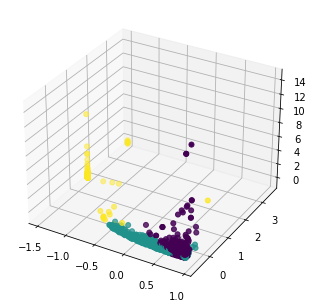

In [41]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=test_pred_gnb, s=25)
plt.show()